<a href="https://colab.research.google.com/github/dchug2/ATMS597_Project6_GroupA/blob/master/NN_to_rule_the_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import xarray as xr
from google.colab import drive
import os
import pandas as pd
import sklearn
%pylab inline
drive.mount('/content/gdrive')

# uncomment for Div
# os.chdir('/content/gdrive/My Drive/Academics/ATMS597_dataanalysis/Project6/ATMS597_Project6_RoRaDi')
# uncomment for Randy
os.chdir('/content/gdrive/My Drive/ATMS597_Project6_RoRaDi/')

Populating the interactive namespace from numpy and matplotlib
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7af70c89e8>,
      dtype=object)

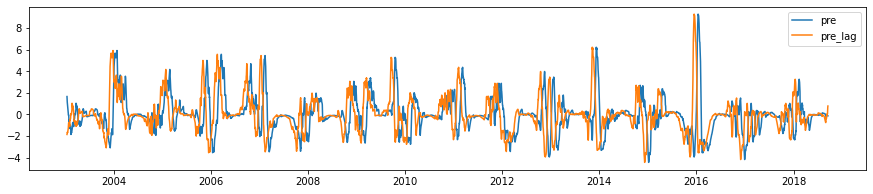

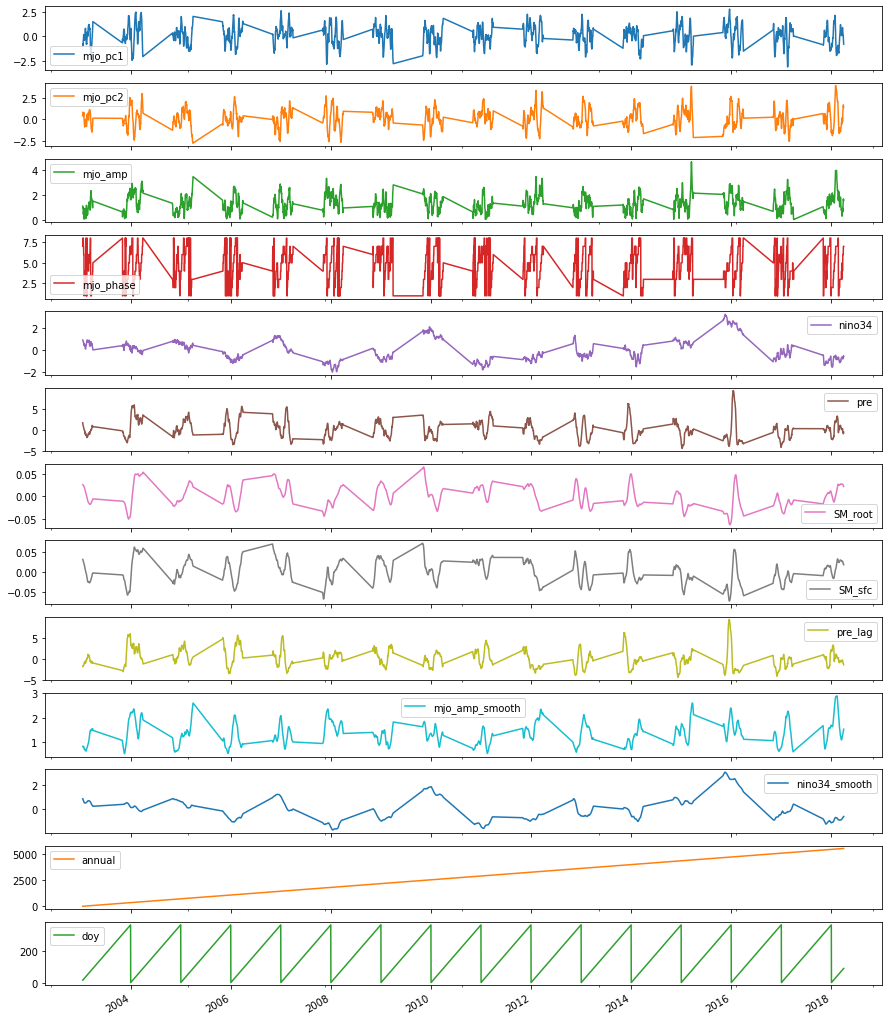

In [0]:
# load data
# MLE_df = pd.read_pickle('Data/roradi_df_smooth.pkl')
MLE_df = pd.read_pickle('Data/roradi_df_smooth_nino34_mjo.pkl')

# add number of days passed, to capture linear trends
MLE_df['annual'] = (MLE_df.index - MLE_df.index[0]).days

# add DOY to capture any annual cycle dependencies
MLE_df['doy'] = pd.to_datetime(MLE_df.index).dayofyear

# plot precipitation data
MLE_df[['pre', 'pre_lag']].plot(figsize = (15, 3))

# pairwise comparison
#column_names2 = ['pre_lag','pre', 'SM_root', 'SM_sfc', 'oni', 'mjo_amp']
#g = sns.pairplot(MLE_df[column_names2])

# Let's focus on the NDJFM season
datemask = ((pd.to_datetime(MLE_df.index).month >= 11) | (pd.to_datetime(MLE_df.index).month <= 3))
MLE_df = MLE_df.loc[datemask]

# plot all forcings
MLE_df.plot(subplots=True, figsize=(15, 20))

In [0]:
predictand = 'pre_lag'

# split data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = MLE_df[predictand]
X = MLE_df.drop([predictand],axis=1)
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.1,random_state = 10)

# Load Tensorflow

In [0]:
%load_ext tensorboard
# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

2.2.0-rc3


In [0]:
def build_model(input_shape=1,layer_size=64,p=0.2):
  model = keras.Sequential([
    layers.Dense(layer_size, activation='relu', input_shape=[input_shape]),
    layers.BatchNormalization(),
    layers.Dropout(p),
    layers.Dense(layer_size, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(p),
    layers.Dense(layer_size, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(p),
    layers.Dense(layer_size, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(p),
    layers.Dense(layer_size, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(p),
    layers.Dense(layer_size, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(p),
    layers.Dense(1)
  ])

  return model


def train_model(epochs = 100,lr = 0.001,lr_sched=False,input_shape=1,loss='mse',optim='RMSprop',layer_size=64,early_stop=True):
  
  model = build_model(input_shape,layer_size)
  if optim=='RMSprop':
    optimizer = tf.keras.optimizers.RMSprop(lr)
  else:
    optimizer = tf.keras.optimizers.Adam(lr)

  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=['mae', 'mse',tf.keras.metrics.RootMeanSquaredError()])

  logdir = os.path.join("logs", 'NN_allthestops.log')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

  callback = []
  callback.append(tensorboard_callback)
  if lr_sched:
    def scheduler(epoch):
      if epoch < 10:
        return lr 
      else:
        return lr * tf.math.exp(0.1 * (10 - epoch))

    callback.append(tf.keras.callbacks.LearningRateScheduler(scheduler))
  else:
    callback.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10,min_lr=1e-15))

  if early_stop: 
    callback.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=75))

  device_name = tf.test.gpu_device_name()
  if device_name == '/device:GPU:0':
    with tf.device('/device:GPU:0'):
        print("Using GPU")
        model.fit(x=X_train[:,0:input_shape], 
                  y=y_train, 
                  epochs=epochs, 
                  validation_data=(X_test[:,0:input_shape], y_test), 
                  callbacks=[callback])
  else:
      print("Using CPU")
      model.fit(x=X_train[:,0:input_shape], 
                y=y_train, 
                epochs=epochs, 
                validation_data=(X_test[:,0:input_shape], y_test), 
                callbacks=[callback])

  return model 

In [0]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 493), started 1:13:50 ago. (Use '!kill 493' to kill it.)

<IPython.core.display.Javascript object>

In [0]:
model = train_model(epochs=500,lr=0.01,lr_sched=False,input_shape=X.shape[1],layer_size=1024)

Using GPU
Epoch 1/500
66/66 [==============================] - 2s 28ms/step - loss: 21.7493 - mae: 3.1039 - mse: 21.7652 - root_mean_squared_error: 4.6653 - val_loss: 146.1892 - val_mae: 6.8730 - val_mse: 134.9166 - val_root_mean_squared_error: 11.6154 - lr: 0.0100
Epoch 2/500
66/66 [==============================] - 1s 21ms/step - loss: 12.1588 - mae: 2.4416 - mse: 12.1701 - root_mean_squared_error: 3.4886 - val_loss: 167.2231 - val_mae: 7.0482 - val_mse: 178.9296 - val_root_mean_squared_error: 13.3765 - lr: 0.0100
Epoch 3/500
66/66 [==============================] - 1s 21ms/step - loss: 8.8913 - mae: 2.1598 - mse: 8.8686 - root_mean_squared_error: 2.9780 - val_loss: 540.3695 - val_mae: 14.3655 - val_mse: 577.0800 - val_root_mean_squared_error: 24.0225 - lr: 0.0100
Epoch 4/500
66/66 [==============================] - 1s 21ms/step - loss: 5.9407 - mae: 1.8022 - mse: 5.9381 - root_mean_squared_error: 2.4368 - val_loss: 196.2086 - val_mae: 7.2519 - val_mse: 206.7529 - val_root_mean_squar

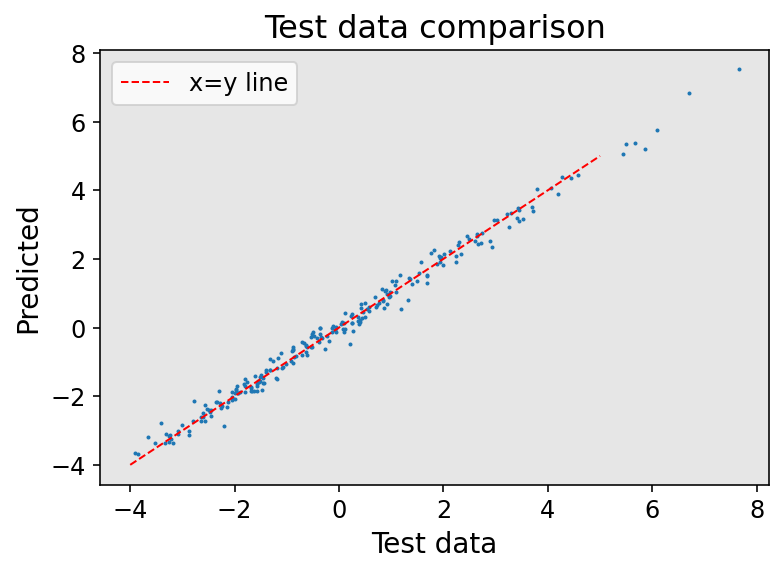

In [0]:
yhat = model.predict(X_test[:,:])
ytest = np.copy(y_test)
p1 = [-4,5]
p2 = [-4,5]
plt.plot(p1,p2,'r--',lw=1.,label='x=y line')
plt.scatter(ytest,yhat[:,0],s=1)
plt.title('Test data comparison',fontsize=16)
plt.ylabel('Predicted',fontsize=14)
plt.xlabel('Test data',fontsize=14)
plt.legend()
# ax.plot([5,10],[5,10])


In [0]:
y_test_binary = np.sign(y_test)
predicted_test_binary = np.sign(yhat[:,0])
compare = np.equal(y_test_binary, predicted_test_binary)*1

# plot the predicted and predictand data
print('Percentage of total predicted values with correct sign =', np.sum(compare)/np.size(compare)*100, '%')

Percentage of total predicted values with correct sign = 97.02127659574468 %


RMSE for training dataset =  0.2266042789653945


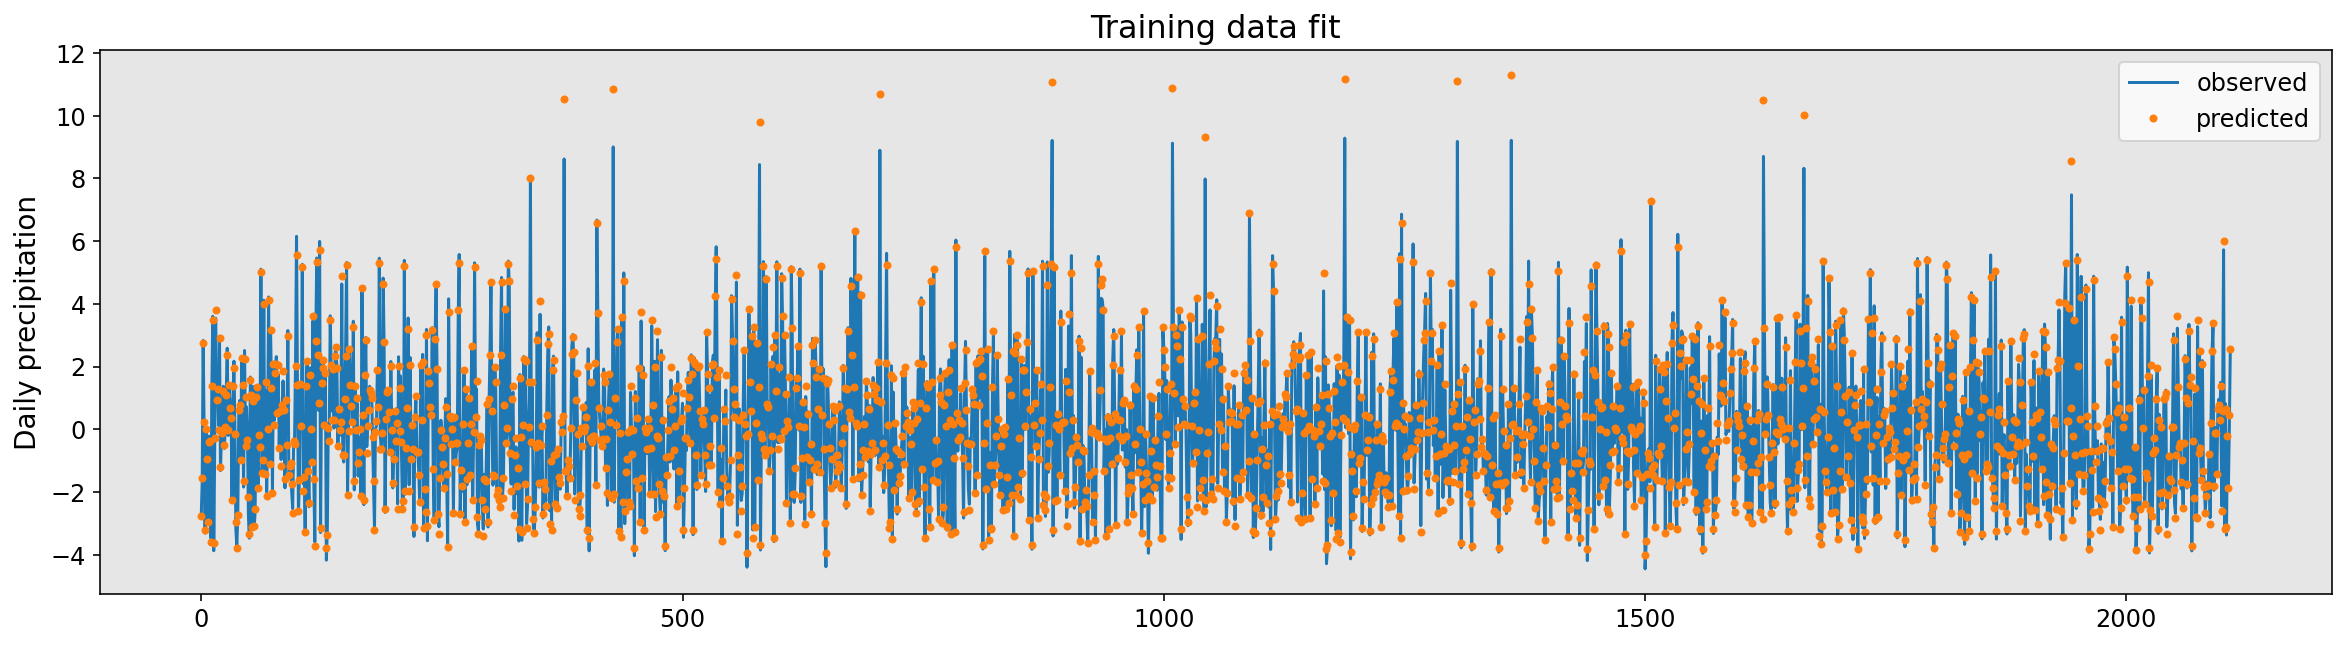

In [0]:
from sklearn.metrics import mean_squared_error
predicted_train =  model.predict(X_train)

# Calculate RMSE on training data
rmse_train = np.sqrt(mean_squared_error(y_train, predicted_train))
print('RMSE for training dataset = ', rmse_train)

# # plot the predicted and predictand data
fig, ax = plt.subplots(figsize = (20, 5))
xidx = np.arange(np.size(y_train))
plt.plot(xidx, y_train, label = 'observed')
plt.plot(xidx, predicted_train, '.',label = 'predicted')
plt.title('Training data fit', fontsize = 16)
plt.ylabel('Daily precipitation', fontsize = 14)
plt.legend(loc = 'best')
plt.show()

RMSE for test dataset =  0.2183956195342106


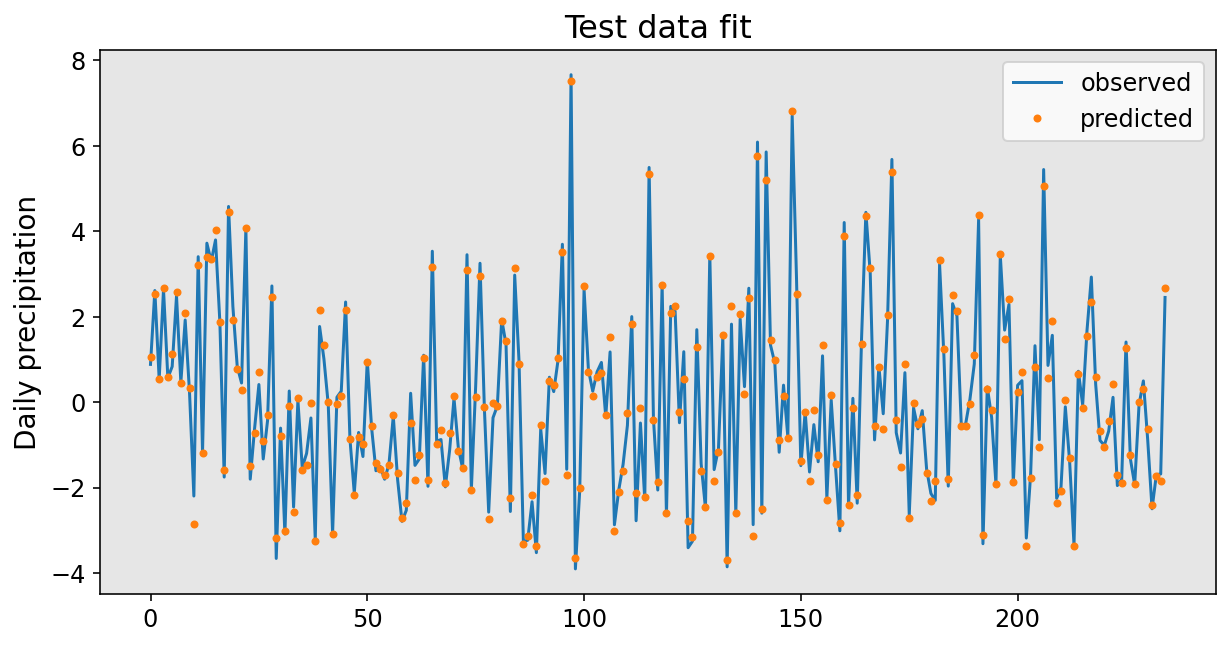

In [0]:
# Evaluate on test data
predicted_test =  model.predict(X_test)
# Calculate RMSE on test data
rmse_test = np.sqrt(mean_squared_error(y_test, predicted_test))
print('RMSE for test dataset = ', rmse_test)

# plot the predicted and predictand data
fig, ax = plt.subplots(figsize = (10, 5))
xidx = np.arange(np.size(y_test))
plt.plot(xidx, y_test, label = 'observed')
plt.plot(xidx, predicted_test, '.',label = 'predicted')
plt.title('Test data fit', fontsize = 16)
plt.ylabel('Daily precipitation', fontsize = 14)
plt.legend(loc = 'best')
plt.show()

In [0]:
weights = model.trainable_weights
w0 = weights[0].numpy()
I = np.zeros(10)
for i in np.arange(0,10):
  I[i] = np.sum(np.abs(w0[i]))

[Text(0, 0, 'mjo_pc1'),
 Text(0, 0, 'mjo_pc2'),
 Text(0, 0, 'mjo_amp'),
 Text(0, 0, 'mjo_phase'),
 Text(0, 0, 'nino34'),
 Text(0, 0, 'pre'),
 Text(0, 0, 'SM_root'),
 Text(0, 0, 'SM_sfc'),
 Text(0, 0, 'mjo_amp_smooth'),
 Text(0, 0, 'nino34_smooth')]

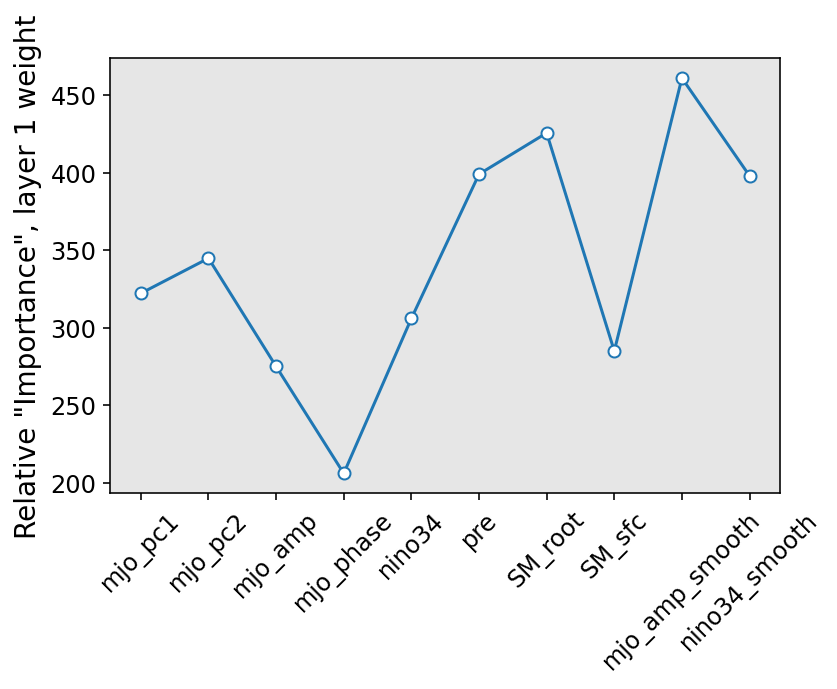

In [0]:
plt.plot(I,'o-',markerfacecolor='w')
plt.ylabel('Relative "Importance", layer 1 weight')
dummylist = plt.gca().get_xticklabels()
plt.gca().set_xticks(np.arange(0,10))
plt.gca().set_xticklabels(list(MLE_df.drop([predictand],axis=1).keys()),rotation=45)

In [0]:
#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
%config InlineBackend.figure_format = 'retina'

In [0]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes,weights=np.ones(240),color=True,alpha=1):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    it = -1 
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                it = it + 1
                if color:
                  if weights[it] < 0:
                    c = 'b'
                  else:
                    c = 'r'
                else:
                  c = 'k'
                  
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c=c,lw=np.abs(weights[it]),alpha=alpha)
                ax.add_artist(line)
                
    plt.axis('off')

In [0]:
w0 = weights[0].numpy()
w_sum = np.sum(w0,axis=0)
for i in np.arange(0,10):
  w0[:,i] = w0[:,i]/w_sum[i]
  
# w1 = weights[2].numpy()
# w_sum = np.sum(w1,axis=0)
# for i in np.arange(0,1):
#   w1[:,i] = w1[:,i]/w_sum[i]

# w2 = weights[4].numpy()
# w_sum = np.sum(w2,axis=0)
# for i in np.arange(0,1):
#   w2[:,i] = w2[:,i]/w_sum[i]

In [0]:
weights[5].numpy()

array([-2.13306069e-01,  8.24512020e-02, -8.75233114e-02, -3.92690420e-01,
       -7.98865557e-02, -1.39727265e-01, -1.17930323e-01, -5.61419949e-02,
       -2.56068647e-01, -1.94009598e-02, -1.46761268e-01, -9.95159447e-02,
        3.11898068e-02, -2.83134460e-01, -2.08477944e-01, -2.97185928e-01,
       -2.81363446e-02, -2.40397424e-01, -3.42638224e-01, -4.54233348e-01,
        7.64243379e-02, -1.15103260e-01,  4.00715545e-02,  1.57533333e-01,
        3.99355069e-02, -5.95804006e-02,  5.97271603e-03, -2.22167909e-01,
        8.90317410e-02, -1.22325875e-01, -1.39320761e-01, -2.16998771e-01,
       -1.33249536e-01, -1.21499682e-02, -6.76338002e-02, -3.96484137e-02,
       -7.56018907e-02, -2.72066861e-01, -6.55265003e-02, -1.13076545e-01,
       -4.05190326e-02, -1.90273210e-01, -3.09779674e-01,  1.11312177e-02,
       -2.47579798e-01, -4.34023201e-01,  1.27697038e-02, -3.15248609e-01,
       -1.90818265e-01, -1.11341849e-01, -5.51492535e-02,  1.10661136e-02,
        2.91886972e-04,  

In [0]:
tw = np.append(np.ravel(w0),np.ravel(w1))
tw= np.append(tw,np.ravel(w2))

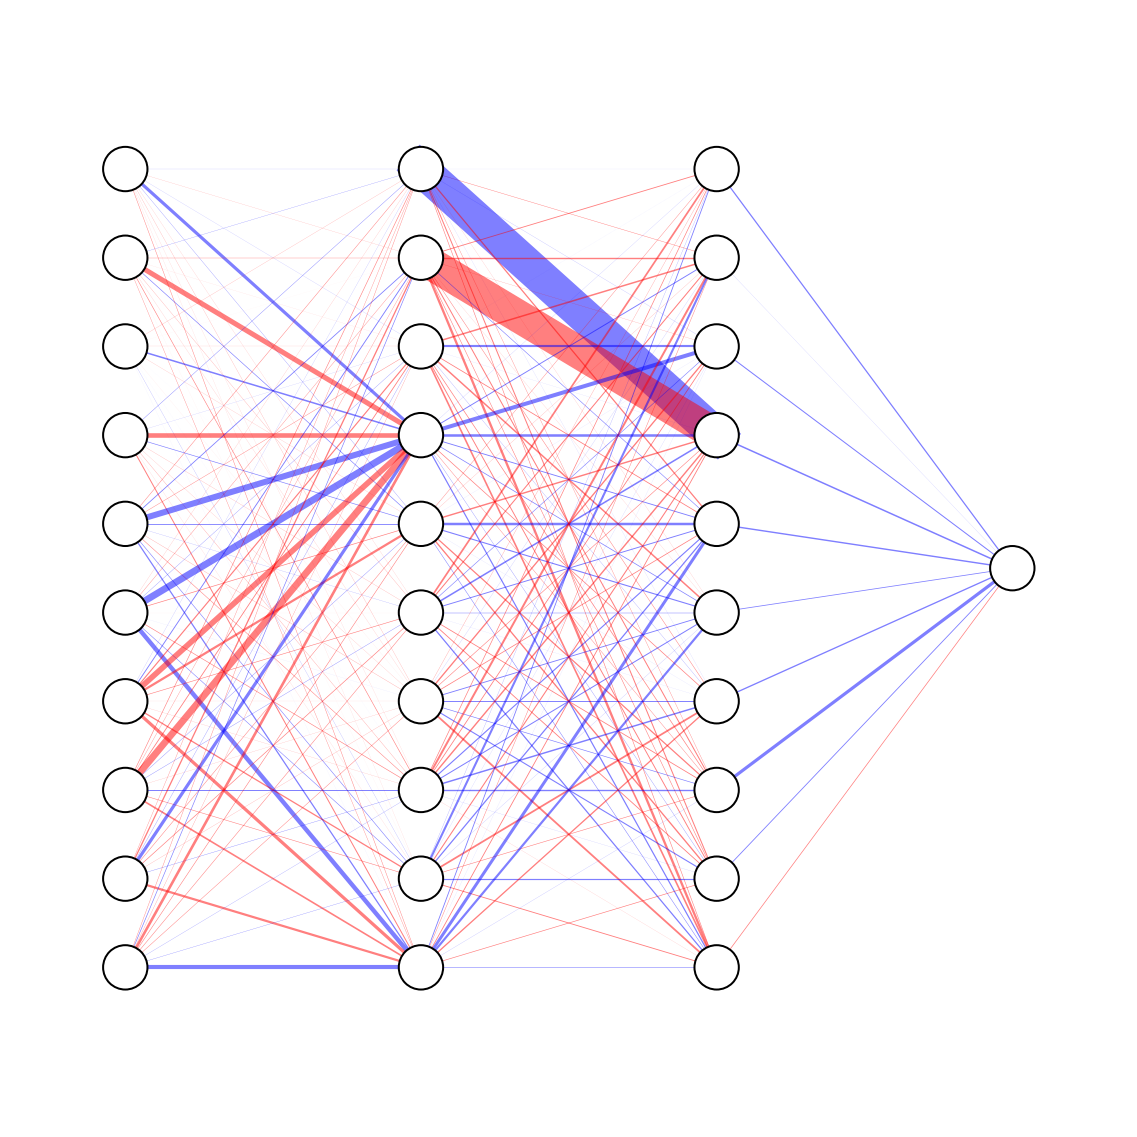

In [0]:
fig = plt.figure(figsize=(8, 8))
draw_neural_net(fig.gca(), .1, .9, .1, .9, [10, 10, 10, 1],weights = tw,alpha=0.5)
plt.tight_layout()

In [0]:
weights[1]

<tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=
array([ 0.3782528 ,  0.03268073,  0.58010125, -0.04281352,  0.38504833,
       -0.33483   , -0.31353563,  0.41068485, -0.08074878, -0.73786783],
      dtype=float32)>

In [0]:
!ls ./logs

Linear_regression_log.gdoc  NN_deep.log  NN_rmse_newdata.log
NN_allthestops.log	    NN_rmse.log  Random_forest_log.gdoc


In [0]:
!rm -rf ./logs/NN_allthestops.log/